# Predicting Customer Ratings

People write about their opinions and experiences with products and services all the time. Wouldn’t it be nice to quantify the positivity or negativity of their words so that businesses could streamline their responsiveness to consumer preferences? In my project, I sought to predict how consumers would rate products, services and businesses based on the text of a review they left.

The main question I was trying to answer was if it’s possible to predict a positive or negative customer review given the text of the review. Specifically, could I create an accurate classification model that correctly differentiates between 1, 2, 3, 4, and 5-star reviews based on the text of the review.

Data was obtained from two Kaggle repositories. The Yelp data is 1,000 reviews by 1,000 different users about 1,000 different businesses. The data obtained from Kaggle was a small portion of the very large Yelp dataset that I initially tried to work with. According to its Kaggle dataset curator, the Amazon dataset consists of reviews from October 1999 to October 2012. Included are 568,454 reviews by 256,059 users about 74,258 products. Overall, the combined dataset has more 5 star reviews than all other categories combined, but There was still a good enough variety of data to put into the models.

This data helped me answer my question because the data included real product or service reviews and how they scored the product or service, so by looking at the words used by real people I was able to tell over time the common words or phrases indicating positive or negative reviews and even the magnitude of positivity or negativity with reasonable accuracy.

## Combining the data

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [64]:
data = pd.read_csv("amazon/Reviews.csv")

In [66]:
amzn = data[["Score", "Text"]]
amzn.columns = ["stars", "text"]

In [4]:
dataY = pd.read_csv("yelp.csv")
yelp = dataY[["stars", "text"]]

In [ ]:
df = amzn.append(yelp).reset_index(drop = True)

This is the dataframe that will be used which has both Yelp and Amazon sourced data.

In [21]:
display(df)

,stars,text,source
0,5,I have bought several of the Vitality canned d...,Amazon
1,1,Product arrived labeled as Jumbo Salted Peanut...,Amazon
2,4,This is a confection that has been around a fe...,Amazon
3,2,If you are looking for the secret ingredient i...,Amazon
4,5,Great taffy at a great price. There was a wid...,Amazon
...,...,...,...
578449,3,First visit...Had lunch here today - used my G...,Yelp
578450,4,Should be called house of deliciousness!\n\nI ...,Yelp
578451,4,I recently visited Olive and Ivy for business ...,Yelp
578452,2,My nephew just moved to Scottsdale recently so...,Yelp


Not much data cleaning had to occur other than the removal of English stop words, but a key part in the analysis was creating a numeric representation of text sentiment. For this, I used the VADER sentiment analysis tool (https://github.com/cjhutto/vaderSentiment) which was designed for analyzing social media posts. I decided to use this method because I’m assuming that people post similarly on social media and in online reviews since in both situations people are writing to a semi-unknown audience in a casual setting. The VADER compound score that was used is a number in the range (-1, 1) where scores at the edges of the range are more extremely positive or negative, and scores close to zero are generally neutral.

## Feature Creation: Getting the VADER Compound Sentiment Score

In [73]:
from nltk import wordpunct_tokenize, word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [74]:
tokens = df['text'].apply(lambda x: wordpunct_tokenize(x))
df['tokens'] = tokens

In [75]:
sw = stopwords.words('english')

In [76]:
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in sw])

In [77]:
sid = SentimentIntensityAnalyzer()

In [78]:
df['scores'] = df['tokens'].apply(lambda x: sid.polarity_scores(" ".join(x))['compound'])

Once I calculated the sentiment score, this what the dataframe looked like.

In [79]:
display(df)

,stars,text,source,tokens,scores
0,5,I have bought several of the Vitality canned d...,Amazon,"[I, bought, several, Vitality, canned, dog, fo...",0.9413
1,1,Product arrived labeled as Jumbo Salted Peanut...,Amazon,"[Product, arrived, labeled, Jumbo, Salted, Pea...",0.0762
2,4,This is a confection that has been around a fe...,Amazon,"[This, confection, around, centuries, ., It, l...",0.8073
3,2,If you are looking for the secret ingredient i...,Amazon,"[If, looking, secret, ingredient, Robitussin, ...",0.4404
4,5,Great taffy at a great price. There was a wid...,Amazon,"[Great, taffy, great, price, ., There, wide, a...",0.9468
...,...,...,...,...,...
578449,3,First visit...Had lunch here today - used my G...,Yelp,"[First, visit, ..., Had, lunch, today, -, used...",0.8807
578450,4,Should be called house of deliciousness!\n\nI ...,Yelp,"[Should, called, house, deliciousness, !, I, c...",0.9925
578451,4,I recently visited Olive and Ivy for business ...,Yelp,"[I, recently, visited, Olive, Ivy, business, l...",0.9937
578452,2,My nephew just moved to Scottsdale recently so...,Yelp,"[My, nephew, moved, Scottsdale, recently, bunc...",-0.9491


## Models to predict star rating

There was enough data in each star category in general to train models, but one might be interested in the distribution of star ratings in the datasets and combined.

The Amazon dataset was many times larger than the Yelp dataset, so the distribution of the combined dataset is dominated by the Amazon data distribution of star ratings.

Below we see first the Amazon distribution of star ratings followed by the Yelp distribution, and finally the combined dataset.

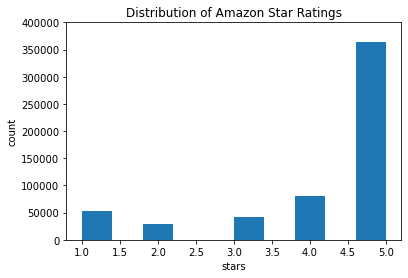

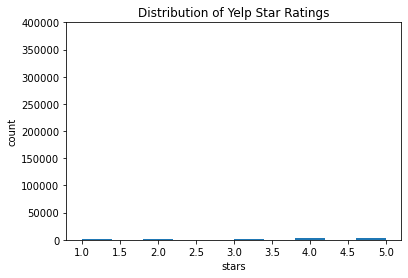

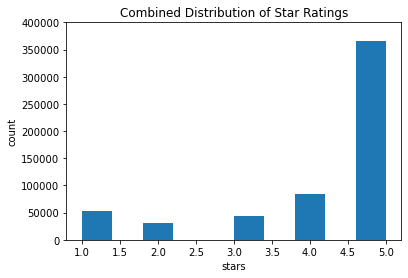

In [83]:
plt.hist(amzn['stars'], bins=10)
plt.title("Distribution of Amazon Star Ratings"); plt.xlabel("stars"); plt.ylabel("count"); plt.ylim((0,400000)); plt.show()

plt.hist(yelp['stars'], bins=10)
plt.title("Distribution of Yelp Star Ratings"); plt.xlabel("stars"); plt.ylabel("count"); plt.ylim((0,400000)); plt.show()

plt.hist(df['stars'], bins=10)
plt.title("Combined Distribution of Star Ratings"); plt.xlabel("stars"); plt.ylabel("count"); plt.ylim((0,400000)); plt.show()

In [23]:
from sklearn.model_selection import train_test_split

In [59]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [94]:
train, test = train_test_split(df, test_size=.3, stratify=df.stars, random_state=315)

### Multinomial Naive Bayes

In [123]:
nb = MultinomialNB()

nb.fit(np.array(train['scores'] + 1).reshape(-1, 1), train['stars'])

yhat = nb.predict(np.array(test['scores'] + 1).reshape(-1, 1))

#match = np.where(yhat == test['stars'], 1, 0)
#np.mean(match) # ACCURACY

print("Multinomial Naive Bayes")
print("F1 Score:\t", f1_score(test['stars'], yhat, average = 'weighted'))
print("Accuracy Score:\t", accuracy_score(test['stars'], yhat))
#print("Precision Score:", precision_score(test['stars'], yhat, average = 'weighted'))
print("Recall Score:\t", recall_score(test['stars'], yhat, average = 'weighted'))

Multinomial Naive Bayes
F1 Score:	 0.4913815097099383
Accuracy Score:	 0.6335133141635502
Recall Score:	 0.6335133141635502


### Random forest classifier

In [119]:
rfc = RandomForestClassifier()

rfc.fit(np.array(train['scores']).reshape(-1, 1), train['stars'])

yhat = rfc.predict(np.array(test['scores']).reshape(-1, 1))

#match = np.where(yhat == test['stars'], 1, 0)
#np.mean(match) # ACCURACY

print("Random Forest Classifier")
print("F1 Score:\t", f1_score(test['stars'], yhat, average = 'weighted'))
print("Accuracy Score:\t", accuracy_score(test['stars'], yhat))
print("Precision Score:", precision_score(test['stars'], yhat, average = 'weighted'))
print("Recall Score:\t", recall_score(test['stars'], yhat, average = 'weighted'))

Random Forest Classifier
F1 Score:	 0.5573812923671442
Accuracy Score:	 0.6544483309034961
Precision Score: 0.5715898267542256
Recall Score:	 0.6544483309034961


## Models to detect a positive star rating

In this section I use a different target variable - 'positive' to train models to differentiate between negative reviews (1&2 stars) and positive reviews (4&5 stars).

In [131]:
df_no_3 = df.loc[df['stars'] != 3,:].reset_index()

In [132]:
df_no_3['positive'] = df_no_3['stars'].apply(lambda x: 1 if x > 3 else 0)

In [135]:
train_2, test_2 = train_test_split(df_no_3, test_size=.3, stratify=df_no_3['positive'], random_state=754)

### Multinomial Naive Bayes

In [148]:
nb = MultinomialNB()

nb.fit(np.array(train_2['scores'] + 1).reshape(-1, 1), train_2['positive'])

yhat = nb.predict(np.array(test_2['positive'] + 1).reshape(-1, 1))

#match = np.where(yhat == test['stars'], 1, 0)
#np.mean(match) # ACCURACY

print("Multinomial Naive Bayes")
print("F1 Score:\t", f1_score(test_2['positive'], yhat, average = 'weighted'))
print("Accuracy Score:\t", accuracy_score(test_2['positive'], yhat))
#print("Precision Score:", precision_score(test_2['positive'], yhat, average = 'weighted'))
print("Recall Score:\t", recall_score(test_2['positive'], yhat, average = 'weighted'))

Multinomial Naive Bayes
F1 Score:	 0.7716629664127549
Accuracy Score:	 0.8433371177622796
Recall Score:	 0.8433371177622796


### Random forest classifier

In [149]:
rfc = RandomForestClassifier()

rfc.fit(np.array(train_2['scores'] + 1).reshape(-1, 1), train_2['positive'])

yhat = rfc.predict(np.array(test_2['positive'] + 1).reshape(-1, 1))

#match = np.where(yhat == test['stars'], 1, 0)
#np.mean(match) # ACCURACY


In [147]:
print("Random Forest Classifier")
print("F1 Score:\t", f1_score(test_2['positive'], yhat, average = 'weighted'))
print("Accuracy Score:\t", accuracy_score(test_2['positive'], yhat))
print("Precision Score:", precision_score(test_2['positive'], yhat, average = 'weighted'))
print("Recall Score:\t", recall_score(test_2['positive'], yhat, average = 'weighted'))

Random Forest Classifier
F1 Score:	 0.7716629664127549
Accuracy Score:	 0.8433371177622796
Precision Score: 0.711217494195589
Recall Score:	 0.8433371177622796
